In [1]:
import os
print(os.listdir('../input/flowers/flowers'))

['rose', 'dandelion', 'daisy', 'sunflower', 'tulip']


In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
import keras
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


In [3]:
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 50
INPUT_SHAPE = (32, 32, 3)
WEIGHT_DECAY = 1e-4
KFOLD_WEIGHT_PATH=r'cnn_cifar10_weights_{epoch:02d}_{val_acc:.2f}.hdf5'

In [4]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='../input/flowers/flowers/daisy'
FLOWER_SUNFLOWER_DIR='../input/flowers/flowers/sunflower'
FLOWER_TULIP_DIR='../input/flowers/flowers/tulip'
FLOWER_DANDI_DIR='../input/flowers/flowers/dandelion'
FLOWER_ROSE_DIR='../input/flowers/flowers/rose'


In [5]:
def assign_label(img,flower_type):
    return flower_type
    

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        
        
        

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 769/769 [00:03<00:00, 192.63it/s]

769


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 734/734 [00:04<00:00, 169.94it/s]

1503


In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:05<00:00, 182.67it/s]

2487


In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

 20%|█▉        | 210/1055 [00:01<00:04, 181.76it/s]


error: OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:04<00:00, 195.16it/s]

3481


## 2.2 ) Visualizing some Random Images

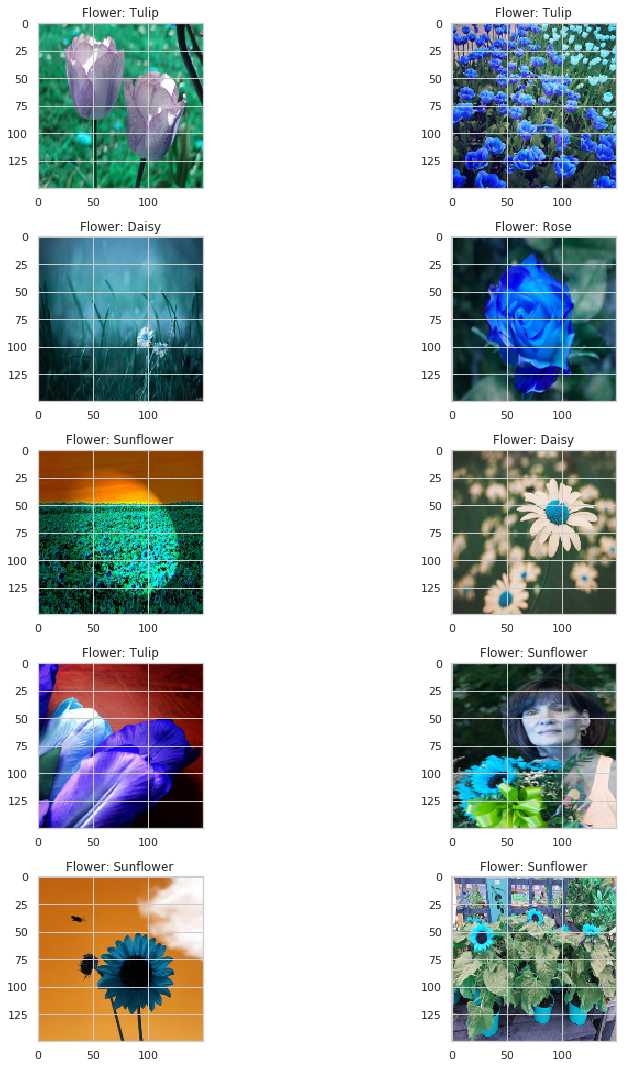

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [13]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [14]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [15]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [40]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

#model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Compiling the Keras Model & Summary

In [43]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 75, 75, 96)        27744     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 37, 37, 96)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 131424)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               67289600  
_________________________________________________________________
activation_5 (Activation)    (None, 512)              

## 3.3 ) Fitting on the Training set and making predcitons on the Validation set

In [45]:
History = model.fit(x_train,y_train, batch_size=BATCH_SIZE,
                              epochs = EPOCHS, validation_data = (x_test,y_test),
                              verbose = 1)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Train on 2610 samples, validate on 871 samples
Epoch 1/50
2610/2610 [==============================] - 4s 2ms/step - loss: 2.5752 - accuracy: 0.3023 - val_loss: 1.5850 - val_accuracy: 0.2549
Epoch 2/50
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3543 - accuracy: 0.4038 - val_loss: 1.1982 - val_accuracy: 0.5109
Epoch 3/50
2610/2610 [==============================] - 4s 1ms/step - loss: 1.1848 - accuracy: 0.5077 - val_loss: 1.0512 - val_accuracy: 0.5775
Epoch 4/50
2610/2610 [==============================] - 4s 1ms/step - loss: 1.1182 - accuracy: 0.5506 - val_loss: 1.0106 - val_accuracy: 0.6165
Epoch 5/50
2610/2610 [==============================] - 4s 1ms/step - loss: 1.0273 - accuracy: 0.5877 - val_loss: 1.0323 - val_accuracy: 0.5545
Epoch 6/50
2610/2610 [==============================] - 4s 1ms/step - loss: 1.0095 - accuracy: 0.5874 - val_loss: 0.9675 - val_accuracy: 0.6142
Epoch 7/50
2610/2610 [==============================] - 4s 1ms/step - loss: 0.8961 - accu

In [46]:
score = model.evaluate(x_test, y_test, verbose=1)

871/871 [==============================] - 0s 472us/step


In [47]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.483435648864501
Test accuracy: 0.5843857526779175


<a id="content4"></a>
## 4 ) Evaluating the Model Performance

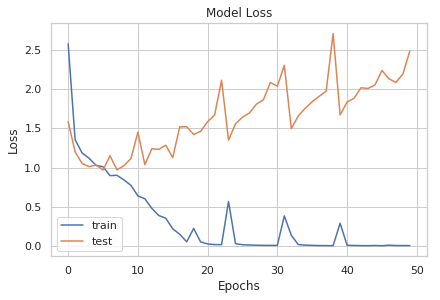

In [48]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

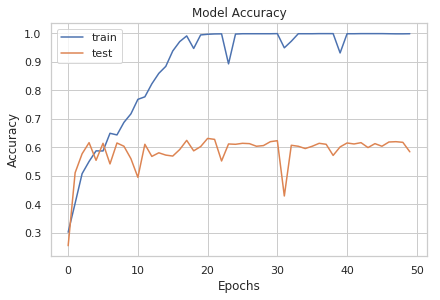

In [49]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
